In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Đường dẫn tới file CSV của dataset
file_path = '/home/ducanh/Credit Card Transactions Fraud Detection/Datasets/combined_data.csv'

# Load dữ liệu
df = pd.read_csv(file_path)

In [22]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 25 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Unnamed: 0             int64         
 1   trans_date_trans_time  datetime64[ns]
 2   cc_num                 int64         
 3   merchant               object        
 4   category               object        
 5   amt                    float64       
 6   first                  object        
 7   last                   object        
 8   gender                 object        
 9   street                 object        
 10  city                   object        
 11  state                  object        
 12  zip                    int64         
 13  lat                    float64       
 14  long                   float64       
 15  city_pop               int64         
 16  job                    object        
 17  dob                    object        
 18  trans_num             

In [11]:
# Chuyển đổi trans_date_trans_time sang datetime và trích xuất giờ giao dịch
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_hour'] = df['trans_date_trans_time'].dt.hour  # sử dụng .dt.hour để lấy số giờ
df['trans_date_trans_time_numeric'] = df['trans_date_trans_time'].apply(lambda x: x.timestamp())

# Chuyển đổi dob sang datetime và tính tuổi (dựa trên năm 2021)
df['dob'] = pd.to_datetime(df['dob'])
df['cust_age'] = 2021 - df['dob'].dt.year

# Tạo nhóm tuổi dựa trên cust_age
df['cust_age_groups'] = df['cust_age'].apply(lambda x: 'below 10' if x < 10 else (
    '10-20' if 10 <= x < 20 else (
    '20-30' if 20 <= x < 30 else (
    '30-40' if 30 <= x < 40 else (
    '40-50' if 40 <= x < 50 else (
    '50-60' if 50 <= x < 60 else (
    '60-70' if 60 <= x < 70 else (
    '70-80' if 70 <= x < 80 else 'Above 80'))))))))
    
# Sử dụng pivot table để tính giá trị trung bình của amt theo cust_age_groups và is_fraud
age_piv_2 = pd.pivot_table(data=df,
                           index='cust_age_groups',
                           columns='is_fraud',
                           values='amt',
                           aggfunc=np.mean)
age_piv_2.sort_values(by=1, ascending=True, inplace=True)
age_dic = {k: v for (k, v) in zip(age_piv_2.index.values, age_piv_2.reset_index().index.values)}
df['cust_age_groups'] = df['cust_age_groups'].map(age_dic)

# --- Xử lý các biến categorical khác ---
# Ánh xạ biến category (dựa trên giao dịch gian lận)
merch_cat = df[df['is_fraud'] == 1].groupby('category')['amt'].mean().sort_values(ascending=True)
merch_cat_dic = {k: v for (k, v) in zip(merch_cat.index.values, merch_cat.reset_index().index.values)}
df['category'] = df['category'].map(merch_cat_dic)

# Ánh xạ biến job
job_txn_piv_2 = pd.pivot_table(data=df,
                               index='job',
                               columns='is_fraud',
                               values='amt',
                               aggfunc=np.mean)
job_cat_dic = {k: v for (k, v) in zip(job_txn_piv_2.index.values, job_txn_piv_2.reset_index().index.values)}
df['job'] = df['job'].map(job_cat_dic)

# --- Chuẩn hóa và mã hóa các biến ---
# Chuyển trans_hour thành số nguyên (nếu chưa)
df['trans_hour'] = df['trans_hour'].astype(int)

# Mã hóa biến gender thành các biến nhị phân
df = pd.get_dummies(data=df, columns=['gender'], drop_first=True, dtype='int')

/tmp/ipykernel_32679/655121858.py:21: FutureWarning: The provided callable <function mean at 0x730a581815a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  age_piv_2 = pd.pivot_table(data=df,
/tmp/ipykernel_32679/655121858.py:37: FutureWarning: The provided callable <function mean at 0x730a581815a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  job_txn_piv_2 = pd.pivot_table(data=df,


In [12]:
# Các cột cần chuyển: merchant, first, last, street, city, state, zip
cols_to_encode = ['merchant', 'first', 'last', 'street', 'city', 'state', 'zip']
for col in cols_to_encode:
    df[col + '_num'] = pd.factorize(df[col])[0]

In [13]:
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
# Nếu cần, loại bỏ một số cột định danh không muốn tính (ví dụ: trans_date_trans_time)
if 'trans_date_trans_time' in numeric_features:
    numeric_features.remove('trans_date_trans_time')

# Tính ma trận tương quan
corr_matrix = df[numeric_features].corr()

# Lấy hệ số tương quan giữa các feature với nhãn is_fraud
corr_with_label = corr_matrix['is_fraud'].drop('is_fraud')

# Sắp xếp theo độ tương quan tuyệt đối tăng dần (các feature có tương quan thấp nhất)
lowest_corr = corr_with_label.abs().sort_values(ascending=True)
lowest_corr_df = lowest_corr.reset_index()
lowest_corr_df.columns = ['Feature', 'Correlation_with_is_fraud']

# Sắp xếp theo độ tương quan tuyệt đối giảm dần (các feature có tương quan cao nhất)
highest_corr = corr_with_label.abs().sort_values(ascending=False)
highest_corr_df = highest_corr.reset_index()
highest_corr_df.columns = ['Feature', 'Correlation_with_is_fraud']

In [14]:
print("Các feature có độ tương quan thấp nhất với is_fraud:")
print(lowest_corr_df)

Các feature có độ tương quan thấp nhất với is_fraud:
                          Feature  Correlation_with_is_fraud
0                        city_pop                   0.000325
1                      Unnamed: 0                   0.000524
2                      merch_long                   0.000999
3                            long                   0.001022
4                          cc_num                   0.001125
5                             job                   0.001388
6                             zip                   0.002190
7                       state_num                   0.002369
8                       merch_lat                   0.002778
9                             lat                   0.002904
10                       gender_M                   0.005844
11                      first_num                   0.009252
12                       cust_age                   0.011103
13                cust_age_groups                   0.012817
14                     trans_hou

In [15]:
print("\nCác feature có độ tương quan cao nhất với is_fraud:")
print(highest_corr_df)


Các feature có độ tương quan cao nhất với is_fraud:
                          Feature  Correlation_with_is_fraud
0                             amt                   0.209308
1                        is_night                   0.104413
2                        category                   0.041894
3                      street_num                   0.032646
4                         zip_num                   0.032297
5                        city_num                   0.027851
6                    merchant_num                   0.024758
7                        last_num                   0.014406
8                       unix_time                   0.013329
9   trans_date_trans_time_numeric                   0.013310
10                     trans_hour                   0.013196
11                cust_age_groups                   0.012817
12                       cust_age                   0.011103
13                      first_num                   0.009252
14                       gender_

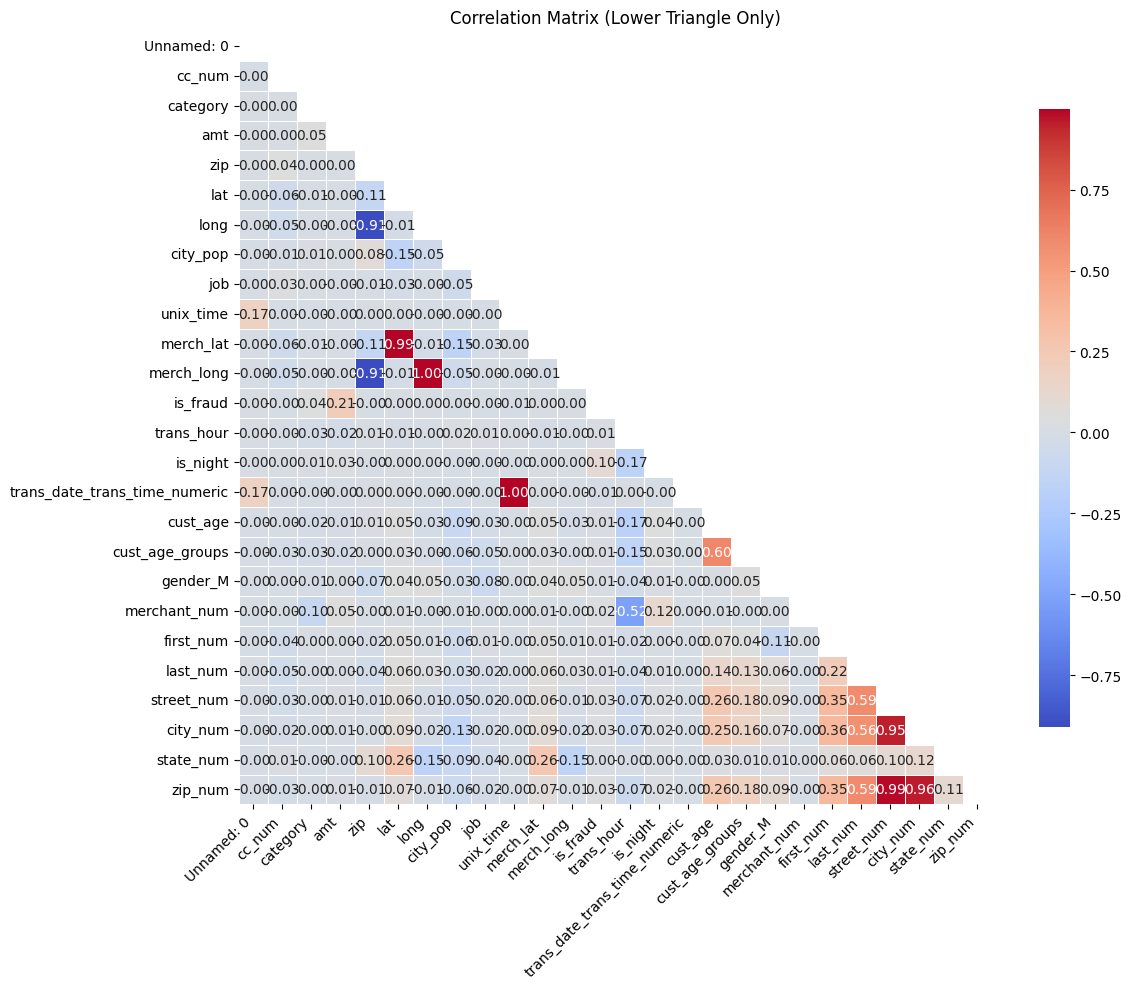

In [16]:
# Tạo mask để chỉ hiển thị tam giác dưới (dưới đường chéo chính)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,           # Ẩn tam giác trên
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    linewidths=.5,
    cbar_kws={"shrink": .8}
)

plt.title("Correlation Matrix (Lower Triangle Only)")
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục X cho dễ đọc
plt.tight_layout()
plt.show()

Spatial-Temporal 3D tensor constructions

In [ ]:
import numpy as np
import pandas as pd

# --------------------------
# 1. Data Loading and Preprocessing
# --------------------------
# Update the CSV file path as needed.
csv_path = r'/home/ducanh/Credit Card Transactions Fraud Detection/Datasets/combined_data.csv'
df = pd.read_csv(csv_path)

# Convert 'trans_date_trans_time' to datetime and then to a timestamp (in seconds)
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_date_trans_time'] = df['trans_date_trans_time'].apply(lambda x: x.timestamp())

# Ensure 'zip' is numeric (spatial attribute)
df['zip'] = df['zip'].astype(int)

# --------------------------
# 2. Feature Selection for the Tensor
# --------------------------
# We will use zip code for spatial grouping, so it is excluded from the feature vector.
# Selected features (numeric) for the feature slice:
selected_features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'is_night']

# --------------------------
# 3. Build the 3D Tensor Using a True Spatial Attribute (zip code)
# --------------------------
def build_3d_tensor(df, time_window_sec, spatial_col, feature_cols, agg_func=np.mean):
    """
    Constructs a 3D tensor from the DataFrame.
    
    Parameters:
      df: pandas DataFrame with transaction records.
          Must include a timestamp column ('trans_date_trans_time').
      time_window_sec: Time window (in seconds) to create temporal slices.
      spatial_col: Column name to use for spatial grouping (e.g., 'zip').
      feature_cols: List of column names to use as features.
      agg_func: Aggregation function to combine multiple transactions in the same bin (default: np.mean).
      
    Returns:
      tensor: NumPy array of shape (num_temporal_slices, num_spatial_slices, num_features)
      temporal_bins: Sorted list of unique temporal bin indices.
      spatial_bins: Sorted list of unique spatial values.
    """
    df = df.copy()
    # Create a 'time_bin' column based on the specified time window
    df['time_bin'] = (df['trans_date_trans_time'] // time_window_sec).astype(int)
    
    # Get sorted unique bins for temporal and spatial dimensions
    temporal_bins = sorted(df['time_bin'].unique())
    spatial_bins = sorted(df[spatial_col].unique())
    
    num_temporal = len(temporal_bins)
    num_spatial = len(spatial_bins)
    num_features = len(feature_cols)
    
    # Initialize the tensor with zeros
    tensor = np.zeros((num_temporal, num_spatial, num_features))
    
    # For each temporal and spatial bin, aggregate the feature values
    for i, t in enumerate(temporal_bins):
        for j, s in enumerate(spatial_bins):
            sub_df = df[(df['time_bin'] == t) & (df[spatial_col] == s)]
            if not sub_df.empty:
                tensor[i, j, :] = agg_func(sub_df[feature_cols], axis=0)
            else:
                tensor[i, j, :] = 0  # Alternatively, use np.nan to indicate missing values
    return tensor, temporal_bins, spatial_bins

# Set time window to 1 hour (3600 seconds)
time_window_sec = 3600

# Build the tensor using 'zip' for spatial grouping
tensor, temporal_bins, spatial_bins = build_3d_tensor(df, time_window_sec, spatial_col='zip', feature_cols=selected_features)

# --------------------------
# 4. Output the Results
# --------------------------
print("3D Tensor shape:", tensor.shape)
print("Temporal bins (each represents a 1-hour window):", temporal_bins)
print("Spatial bins (unique zip codes):", spatial_bins)

# For demonstration, print the aggregated feature vector for the first temporal slice and first spatial slice
print("\nExample tensor cell (first temporal bin, first spatial bin):")
print(tensor[0, 0, :])